In [14]:
from control import *
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# kp, ki, kd
# 0.005493331705679495, 0.00024414807580797754, 30.81524926686217
# 3.9100684261974585, 18.57282502443793, 912.0234604105572
# 0.9775171065493646, 0.9775171065493646, 999.0224828934506
kp = 0.9775171065493646
ki = 0.9775171065493646
kd = 999.02

In [26]:
plant = tf([1], [64,9.6,0.48,0.008])
pid = tf([kd,kp,ki], [1,0])

In [27]:
plant


                1
---------------------------------
64 s^3 + 9.6 s^2 + 0.48 s + 0.008

In [28]:
sys = feedback(pid, plant, sign=1)

In [41]:
time = np.arange(0,90)

In [42]:
sys1 = feedback(pid*plant, 1)

<function matplotlib.pyplot.show>

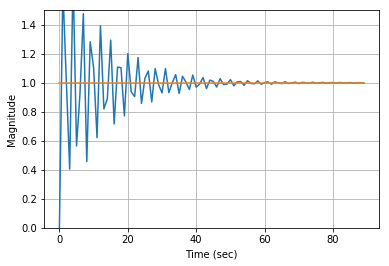

In [43]:
# PID compensated Step Response
t, s = step_response(sys1,T=time)
target = np.linspace(1, 1, num=len(t))
plt.figure()
plt.plot(t,s,t,target)
#plt.plot(t,s)
plt.ylim([0,1.5])
plt.ylabel(r'Magnitude')
plt.xlabel(r'Time (sec)')
plt.grid()
plt.show

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from control import *

In [ ]:
# Plant
num = [1]
den = [64,9.6,0.48,0.008]
G = tf(num, den)

# Plant Step Response
t, s = step_response(G)

#PID Controller
kp = 0.0361 
ki = 0.000731
kd = 0.6999

pid_num = [kd, kp, ki]
pid_den = [1, 0]
C = tf(pid_num,pid_den)

# System
T = feedback(C*G,1)

In [ ]:
# PID compensated Step Response
t, s = step_response(T)
target = np.linspace(1, 1, num=len(t))
plt.figure()
plt.plot(t,s,t,target)
#plt.plot(t,s)
plt.ylim([0,1.5])
plt.ylabel(r'Magnitude')
plt.xlabel(r'Time (sec)')
plt.grid()
plt.show

error = target - s

In [1]:
import matplotlib
import numpy
from control import *
import math

In [2]:
from deap import base, creator
# Crear clase FITNESS: ( Nombre de la clase, Delegando la clase como fitness, Posibles valores min y max del fitness )
creator.create("ControllerFitness", base.Fitness, weights=(-1.0,))

# Crear clase CROMOSOMA: ( Nombre de la clase, type de los valores de la clase, Establecer fitness con la clase anterior )
creator.create("Controller", list, fitness=creator.ControllerFitness)

In [3]:
import random
from deap import tools

IND_SIZE = 30 # ki bits + kp bits + kd bits

# Functions to initialize populations from individuals

toolbox = base.Toolbox()

# Crear el ATRIBUTO de cromosomas ( Nombre del registro para el toolbox, Función para crear un cromosoma aleatorio )
toolbox.register("bit_attribute", random.randint, 0, 1) # random.choice, '10')

# Crear el CROMOSOMA ( Nombre del registro, , La clase cromosoma, La clase atributo, Tamaño de la población )
# Cuando se llame a toolbox.individual(), este llamará a tool.initRepeat()
toolbox.register("controller", tools.initRepeat, creator.Controller, toolbox.bit_attribute, n=IND_SIZE)

# Crear la POBLACIÓN ( Nombre del registro, , Type del cromosoma, El cromosoma )
toolbox.register("population", tools.initRepeat, list, toolbox.controller)

In [4]:
ind = toolbox.controller()

In [5]:
def evaluate(controller):
    controller = ''.join(map(str,controller))
    
    # PID controller
    _kp = int(controller[0:10],2)
    _ki = int(controller[10:20],2)
    _kd = int(controller[20:30],2)
    
    kp = 0 + _kp * ( (1000 - 0) / (math.pow(2,10) - 1) )
    ki = 0 + _ki * ( (1000 - 0) / (math.pow(2,10) - 1) )
    kd = 0 + _kd * ( (1000 - 0) / (math.pow(2,10) - 1) )
    
    # Plant
    num = [1]
    den = [64,9.6,0.48,0.008]
    plant = tf(num, den)
    
    pid_num = [kd, kp, ki]
    pid_den = [1, 0]
    pid = tf(pid_num,pid_den)

    # System
    sys = feedback(pid*plant,1)
    
    # PID compensated Step Response
    t, s = step_response(sys)
    l = len(t)
    
    total_error = sum(abs(1 - s))
    
    #total_error = sum(map(lambda x:abs(1-x)/l,s))
    
    return (total_error),

In [6]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

In [7]:
ind = toolbox.controller()

In [22]:
def main():
    pop = toolbox.population(n=100)
    # pop[0:100] = prev
    CXPB, MUTPB, NGEN = 0.7, 0.1, 100

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    minFit = (1,)
    #while minFit > (0.02,):
    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        minFit = min(fitnesses)
        print("=START=================================================================")
        print(fitnesses)
        print("=END===================================================================")
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring
    
    
    return pop

In [23]:
kx= main()

=START=================================================================
[(7560.155299457611,), (9238.218903891075,), (1.6904051371965878,), (8434.191430126102,), (10729.712072183731,), (2.222711860374246,), (7983.721974773131,), (11355.00112079386,), (6731.186884613838,), (8.074128309061262,), (4876.540007852303,), (6038.631928150665,), (10166.27188755895,), (7.529439923343929,), (7887.00559224956,), (10705.68284330697,), (8.074128309061262,), (10638.268361378934,), (8147.713599106063,), (9874.406414563337,), (7549.508783367867,), (5525.977389335943,), (10.030696187659796,), (9012.903968677252,), (9261.74432221051,), (10797.955796756893,), (9603.389214555104,), (25127978590352.03,), (8343.00536025968,), (7203.397848708227,), (9.829086078810485,), (6700.849117395971,), (5736.895444220561,), (1633870785.7073364,), (11080.458452253408,), (9647.213317127802,), (4.180828533861728,), (6446.025838640406,), (2659.4772410390183,), (6422.194604247561,), (3762045414608.4727,), (8547.246249726915,

=START=================================================================
[(11182.163060664,), (1.5885995237915496,), (1.5785055557483707,), (1.7921096954657505,), (1.362550877495234,), (1.382014389949645,), (1.5327163172713334,), (2.6667205811161994,), (1.412626732824408,), (1.6352010900411655,), (1.3417151711207012,), (1.5369570956744365,), (1.611917288402647,), (3.452315764837281,), (1.313541740355136,), (1.468519960003754,), (1.984653465051518,), (1.6036635348230672,), (1.4173848033294851,), (2.782271728256248,), (1.5661301850712128,), (1.5661301850712128,), (1.5560014699615439,), (1.4170760651326086,), (1.3417151711207012,), (1.3417151711207012,), (1.3166520562944506,), (1.4818304039342447,), (1.733736995482979,), (2.3843049489734263,), (1.3083919062706848,), (6.594926826652845,), (2.358300519413037,), (2.362835196286599,), (1.5369570956744365,), (1.3765179296795553,), (8577.086607317608,), (2.2262336468423287,), (578.1011201664581,), (2621.2589488912827,), (2.358300519413037,), (1.

=START=================================================================
[(1.0763162814541887,), (1.1592349005704352,), (1.1331365995523355,), (1.0372551231575076,), (1.1027055375503416,), (1.1386633183128476,), (1.1175101527693923,), (1.1225280454629019,), (1.1027055375503416,), (1.2526328864790686,), (9923.987065515008,), (1.1468943459273593,), (1.064943708677073,), (1.1105220357298404,), (1.0966149724066416,), (1.1401240638730419,), (1.1194593736451728,), (1.1027055375503416,), (3.8319391743216764,), (1.118140292338523,), (1.2817361753443608,), (1.0817414381624904,), (1.13445621414482,), (1.13445621414482,), (1.1386633183128476,), (1.1588475022615157,), (1.1027055375503416,), (1.151564025793005,), (1.1351368603338583,), (1.151564025793005,), (424.3706000229598,), (1.1728133796158515,), (1.1639361162623085,), (1.1183142361199583,), (1.3849495043973816,), (1.1359526368320378,), (1.064943708677073,), (1.1105220357298404,), (1.0921664695262119,), (1.1532449273151064,), (1.162306049215551

=START=================================================================
[(1.064943708677073,), (1.064943708677073,), (1.0545461279521269,), (1.0372551231575076,), (1.0372551231575076,), (1.0372551231575076,), (1.0372551231575076,), (1.064943708677073,), (1.0843405692419794,), (1.0074771443274568,), (1.1541601013081926,), (1.1114174119804425,), (1.0732853839761403,), (1.0318487308526392,), (1.0318487308526392,), (1.0545461279521269,), (1.0372551231575076,), (1.0372551231575076,), (1.0576468576728397,), (1.0372551231575076,), (1.064943708677073,), (1.0574123170078122,), (1.0372551231575076,), (1.0372551231575076,), (1.1801987910928387,), (1.1605088386101134,), (1.0545461279521269,), (1.0574123170078122,), (1.0545461279521269,), (1.0318487308526392,), (1.0372551231575076,), (1.0799753807689962,), (1.2256468032767285,), (1.0984677141396253,), (1.0545461279521269,), (1.0732853839761403,), (1.0732853839761403,), (1.0576468576728397,), (1.0832085641141147,), (1.0992565066238116,), (1.10581114

=START=================================================================
[(1.0085562246989102,), (1.0073838646098099,), (10119.283935129906,), (1.0074771443274568,), (1.0073191560901689,), (1.4940288763183187,), (1.0035628556629637,), (1.0086452601945117,), (1.0044936871944747,), (1.0046193641622176,), (1.0074771443274568,), (1.0086452601945117,), (1.0334662408414026,), (1.0035628556629637,), (1.0088083743652922,), (2.366467704718259,), (1.0035628556629637,), (1.0073838646098099,), (1.0074771443274568,), (1.0074771443274568,), (1.0046193641622176,), (1.0048081651983045,), (1.009583691914425,), (1.0035628556629637,), (1.0044936871944747,), (1.0044936871944747,), (1.0074771443274568,), (1.0044936871944747,), (1.0074771443274568,), (1.0422071143321894,), (1.0046193641622176,), (1.0046193641622176,), (1.0041297126277895,), (1.0044936871944747,), (1.0088422870889486,), (1.0074771443274568,), (1.0074771443274568,), (1.0085562246989102,), (1.0048081651983045,), (1.0073191560901689,), (1.010993

=START=================================================================
[(1.003494319957718,), (1.003494319957718,), (1.003494319957718,), (1.0035628556629637,), (1.0034708752138042,), (1.0035628556629637,), (1.0193921410523759,), (1.0034708752138042,), (1.003494319957718,), (1.0035592443869537,), (1.0035592443869537,), (1.0034708752138042,), (1.0034708752138042,), (1.0035628556629637,), (1.0034708752138042,), (1.003494319957718,), (1.003494319957718,), (1.0035628556629637,), (1.003494319957718,), (1.003494319957718,), (1.003494319957718,), (1.0050491751314579,), (1.003494319957718,), (1.003494319957718,), (1.0035628556629637,), (3.6108849018634293,), (1.003494319957718,), (1.003494319957718,), (1.0035628556629637,), (1.003443405143308,), (1.7264241485548875,), (1.0034708752138042,), (1.0034708752138042,), (1.0035628556629637,), (1.0035628556629637,), (1.0035628556629637,), (1.003443405143308,), (1.003494319957718,), (1.0035628556629637,), (1.0035628556629637,), (1.003494319957718,), (

=START=================================================================
[(1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.356284983447045e+202,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.7514762478120782,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (366.2815415718061,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (9.555312589856847,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0034708752138042

=START=================================================================
[(1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0037338314287212,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (11247.922275216246,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (nan,), (1.003443405143308,), (1.009603763061215,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143

=START=================================================================
[(1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0047035779837628,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0042108388846183,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0040336891278152,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), 

=START=================================================================
[(1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (2.8291966605615345e+40,), (1.003443405143308,), (10036.12074801553,), (1.003443405143308,), (1.003443405143308,), (1.017783155191485,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,)

=START=================================================================
[(1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (6.766367084083794,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.013415825607301,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (248.76739458216417,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (9.427390428742252e+268,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0047035779837628,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308

=START=================================================================
[(1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (9.599610560039931,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (13

=START=================================================================
[(1.003443405143308,), (386.27283069292724,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0809284943270505,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.702039975021464,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (

=START=================================================================
[(1.003443405143308,), (1.003443405143308,), (1.009603763061215,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.017783155191485,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (2.637210460130257,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.

=START=================================================================
[(1.003443405143308,), (1.003443405143308,), (380.5113953654907,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0152274524740443,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0304924086817133,), (1.003443405143308,), (1.003443405143308,), (9.427390428742252e+268

=START=================================================================
[(1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (7.968592617140911,), (1.003443405143308,), (1.003443405143308,), (1.5407918831904164,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (2.957776926521968,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1

=START=================================================================
[(1.5407918831904164,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.017783155191485,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0378158227780645,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (350.24696311151104,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), 

=START=================================================================
[(1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0338603776404958,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (6.120329036631299,), (nan,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0034434051433

=START=================================================================
[(349.3325310799493,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (9.542223874726583,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.

=START=================================================================
[(1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0152274524740443,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.009603763061215,), (1.003443405143308,), (1.0086823575746489,), (1.003443405143308,), (1.003443405143308,), (2.9845372986201375,), (1.003443405143308,), (7.358114256672527,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (9.641662128435401,), (1.003443405143308,), (1.003443405143308,), (nan,), (7.188354540179588,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0103073207683766,), (1.003443405143308,), (1.003443405143308,), (1.003443405143308,), (1.0034434051

In [24]:
for bits in kx:
    controller = ''.join(map(str,bits))
    
    # PID controller
    _kp = int(controller[0:10],2)
    _ki = int(controller[10:20],2)
    _kd = int(controller[20:30],2)
    
    kp = 0 + _kp * ( (1000 - 0) / (pow(2,10) - 1) )
    ki = 0 + _ki * ( (1000 - 0) / (pow(2,10) - 1) )
    kd = 0 + _kd * ( (1000 - 0) / (pow(2,10) - 1) )
    
    print([_kp,_ki,_kd,kp,ki,kd])

[1, 1, 1022, 0.9775171065493646, 0.9775171065493646, 999.0224828934506]
[1, 1, 1022, 0.9775171065493646, 0.9775171065493646, 999.0224828934506]
[1, 1, 1022, 0.9775171065493646, 0.9775171065493646, 999.0224828934506]
[1, 1, 1022, 0.9775171065493646, 0.9775171065493646, 999.0224828934506]
[1, 1, 1022, 0.9775171065493646, 0.9775171065493646, 999.0224828934506]
[1, 1, 1022, 0.9775171065493646, 0.9775171065493646, 999.0224828934506]
[1, 1, 1022, 0.9775171065493646, 0.9775171065493646, 999.0224828934506]
[1, 1, 1022, 0.9775171065493646, 0.9775171065493646, 999.0224828934506]
[1, 129, 1020, 0.9775171065493646, 126.09970674486804, 997.067448680352]
[1, 1, 1022, 0.9775171065493646, 0.9775171065493646, 999.0224828934506]
[1, 1, 1022, 0.9775171065493646, 0.9775171065493646, 999.0224828934506]
[1, 1, 1022, 0.9775171065493646, 0.9775171065493646, 999.0224828934506]
[1, 17, 1022, 0.9775171065493646, 16.617790811339198, 999.0224828934506]
[1, 1, 1022, 0.9775171065493646, 0.9775171065493646, 999.02248

In [ ]:
evaluate(kx[1])

In [ ]:
list(map(evaluate,kx))

In [ ]:
controller = ''.join(map(str,kx[1]))
    
# PID controller
_kp = int(controller[0:10],2)
_ki = int(controller[10:20],2)
_kd = int(controller[20:30],2)

kp = 0 + _kp * ( (1000 - 0) / (pow(2,10) - 1) )
ki = 0 + _ki * ( (1000 - 0) / (pow(2,10) - 1) )
kd = 0 + _kd * ( (1000 - 0) / (pow(2,10) - 1) )
    
print([_kp,_ki,_kd,kp,ki,kd])